In [24]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import re
import subprocess, os
from src.util import ROOT_DIR
from pathlib import Path

reader = easyocr.Reader(['en'])

In [18]:
# Preprocess cropped license plate image
def preprocess(img) -> cv2.typing.MatLike:
    img_lp = cv2.resize(img, (320, 320))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 200, 255, cv2.THRESH_BINARY_INV)
    # img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    # img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    return img_binary_lp

In [62]:
def read_license_plate(license_plate_crop) -> tuple[tuple[int, int], tuple[int, int], str, float] | tuple[None, None, None, None]:
    height, width = license_plate_crop.shape[:2]
    # processed = preprocess(license_plate_crop)
    processed = cv2.resize(license_plate_crop, (320, 320))
    plate_num_results = reader.readtext(processed)
    for result in plate_num_results:
        bbox, plate_num, score = result
        (x1, y1), _, (x2, y2), _ = bbox
        x1, y1, x2, y2 = x1 * (width/320), y1 * (height/320),x2 * (width/320), y2 * (height/320)
        plate_num = plate_num.upper()
        plate_num = re.sub('[^0-9a-zA-Z]+', '', plate_num)
        if len(plate_num) > 5:
            return (x1, y1), (x2, y2), plate_num, score
    return None, None, None, None

In [61]:
def draw_result(img, plate_num, p1, p2) -> cv2.typing.MatLike:
    (x1, y1), (x2, y2) = p1, p2
    img = cv2.rectangle(img, (int(x1), int(y1)),
                        (int(x2), int(y2)), (0, 255, 0), 6)
    img = cv2.putText(img, plate_num, (int(x1), int(y1)-10),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
    return img

In [45]:
def realesrgan(input_image_path) -> str:
    output_folder = Path(input_image_path).parent.absolute()
    subprocess.run(["python",
                    f"{ROOT_DIR}/Real-ESRGAN/inference_realesrgan.py",
                    "-n",
                    "RealESRGAN_x4plus",
                    "-i",
                    input_image_path,
                    "-o",
                    output_folder,
                    "--outscale",
                    "3.5",
                    "--face_enhance"])
    filepath, ext = os.path.splitext(input_image_path)
    print(filepath, ext)
    output_image_path = f'{filepath}_out{ext}'

    return output_image_path

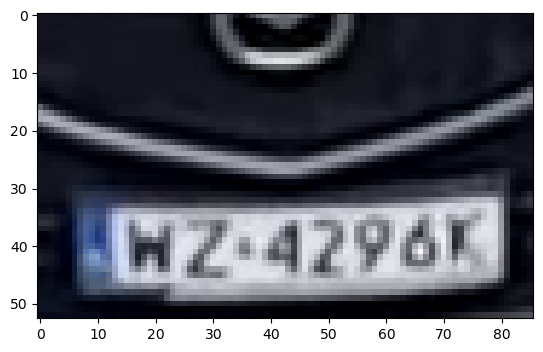

In [67]:
# plate = cv2.imread('../Real-ESRGAN/results/frame_8744_license_plate_0_out.png')
plate = cv2.imread('test.png')
plate = cv2.cvtColor(plate, cv2.COLOR_BGR2RGB) 
plt.imshow(plate)

In [68]:
input_image_path = f'{ROOT_DIR}/tmp_image/tmp.png'
cv2.imwrite(input_image_path, plate)
hd_plate_path = realesrgan(input_image_path)

d:\comp5650\project\stop-sign-camera/tmp_image/tmp .png


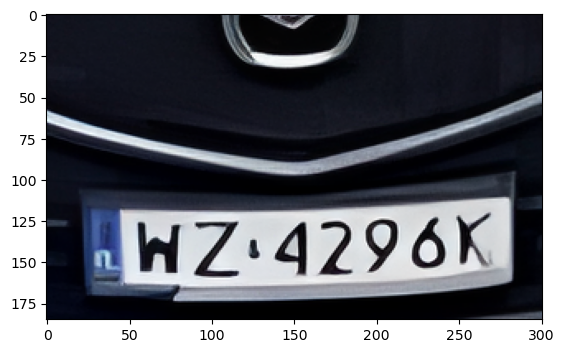

In [69]:
hd_plate = cv2.imread(hd_plate_path)
plt.imshow(hd_plate)

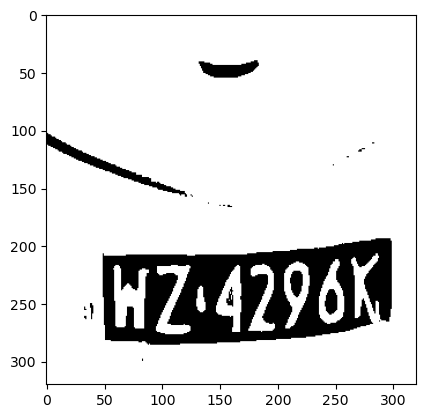

In [70]:
processed = preprocess(hd_plate)
plt.imshow(processed, cmap='gray')

((40.446875, 112.15625),
 (284.06875, 168.234375),
 'HZ4296K',
 0.3226079387439034)

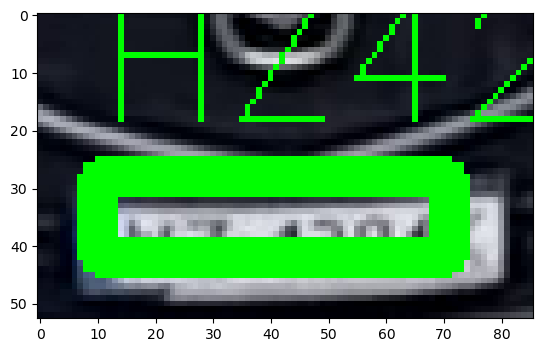

In [71]:
p1, p2, plate_num, _ = read_license_plate(hd_plate)
if plate_num != None:
    (x1, y1), (x2, y2) = p1, p2
    annotated_frame = draw_result(plate, plate_num, (x1/4, y1/4), (x2/4, y2/4))
plt.imshow(annotated_frame)
p1, p2, plate_num, _

In [108]:
import string
def license_complies_format(text):
    if len(text) < 6 or len(text) > 7:
        return False

    if (text[0] in string.ascii_uppercase ) and \
       (text[1] in string.ascii_uppercase ) and \
       (text[2] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) and \
       (text[3] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) and \
       (text[4] in string.ascii_uppercase ) and \
       (text[5] in string.ascii_uppercase ) and \
       (len(text) > 7 text[6] in string.ascii_uppercase ):
        return True
    else:
        return False
    
license_complies_format("AB12BC")

IndexError: string index out of range